In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.manifold import TSNE
from sklearn import datasets, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

### Load and prepare data

In [3]:
x, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.int)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000)  # test_size=10000

In [5]:
scaler = MinMaxScaler().fit(x_train)

In [6]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Embed data

In [7]:
USE_MLP = False
USE_TSNE_OR_PCA = 'PCA'

In [8]:
if USE_MLP:
    mlp = MLPClassifier(hidden_layer_sizes=(200,), random_state=1, max_iter=300).fit(x_train, y_train)
    print('MLP train accuracy {0:3.1f} %'.format(mlp.score(x_train, y_train)*100))
    print('MLP test accuracy {0:3.1f} %'.format(mlp.score(x_test, y_test)*100))
    def sklearn_mlpclassifier_tranform(self, xs):
        return np.dot(xs, self.coefs_[0])
    setattr(MLPClassifier, 'transform', sklearn_mlpclassifier_tranform)
    h_train = mlp.transform(x_train)
    h_test = mlp.transform(x_test)

In [9]:
if USE_TSNE_OR_PCA == 'TSNE':
    if USE_MLP:
        tsne_train = h_train
        tsne_test = h_test
    else:
        tsne_train = x_train
        tsne_test = x_test
    tsne = TSNE(n_components=2, n_iter=300, verbose=3).fit(tsne_train)
    z_train = tsne.transform(tsne_train)
    z_test = tsne.transform(tsne_test)
else:
    if USE_MLP:
        pca_train = h_train
        pca_test = h_test
    else:
        pca_train = x_train
        pca_test = x_test
    pca = PCA(n_components=2).fit(pca_train)
    z_train = pca.transform(pca_train)
    z_test = pca.transform(pca_test)

In [10]:
def plot_mnist(zs, ys):
    for i in range(10):
        idxs = np.argwhere(ys == i)
        plt.scatter(zs[idxs, 0], zs[idxs, 1], label=i)
    plt.legend()
    plt.show()

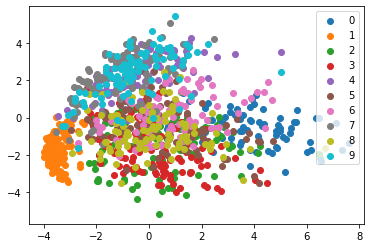

In [11]:
plot_mnist(z_test, y_test)

In [12]:
pca = PCA(n_components=100).fit(x_train)
f_train = pca.transform(x_train)
f_test = pca.transform(x_test)

In [13]:
def euclidean_distance(a, b):
    """ Computes Euclidean distance between to sets of vectors.

    :param a: ndarray (N, K)
    :param b: ndarray (M, K)
    :return: ndarray (N, M)
    """
    ed = np.sqrt(np.mean(np.square(a[:, np.newaxis, :] - b), axis=2))
    return ed


def batch_hard(axs, ays):
    """ Returns hard positives and hard negatives for anchors (axs argument).

    Computes euclidean distance using numpy functionalities (W/O CUDA).
    Then, for each embedding finds farthest embedding as hard positive from the same class.
    As hard negatives it chooses nearest embedding from different class.

    :param axs: ndarray (N, EMBEDDING_SIZE)
    :param ays: ndarray (N,)
    :return: tuple, (hard_positives: ndarray (N, EMBEDDING_SIZE) , hard_negatives: ndarray (N, EMBEDDING_SIZE))
    """
    distance_matrix = euclidean_distance(axs, axs)
    # matrix side size
    ays = ays.reshape(-1, 1)
    num = ays.shape[0]
    diagonal_idxs = np.diag_indices(num)
    # mask items where labels are equal
    y_equals = ays == ays.T
    # let's find HARD POSITIVES
    y_equals[diagonal_idxs] = False
    d2p = distance_matrix.copy()
    # we are going to find hard positive - the most distant positive
    # therefore set -infinity distance to the same items
    d2p[y_equals == False] = -np.inf
    p_idxs = np.argmax(d2p, axis=1)
    hard_positives = axs[p_idxs]
    # let's find HARD NEGATIVES
    d2n = distance_matrix.copy()
    y_equals[diagonal_idxs] = True
    d2n[y_equals == True] = np.inf
    n_idxs = np.argmin(d2n, axis=1)
    hard_negatives = axs[n_idxs]
    return hard_positives, p_idxs, hard_negatives, n_idxs

In [14]:
hard_positives, positive_idxs, hard_negatives, negative_idxs = batch_hard(f_test, y_test)

Here are 5 examples of hard triplets.
anchor -> hard_positive -> hard_negative


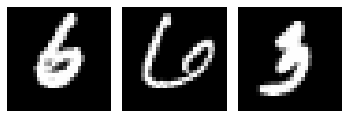

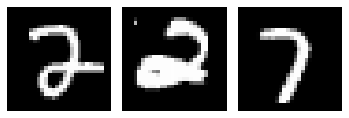

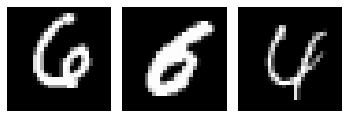

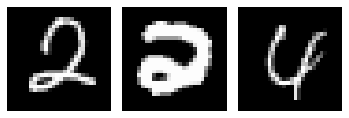

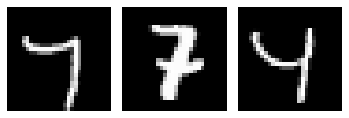

In [15]:
N_EXAMPLES = 5
print(f'Here are {N_EXAMPLES} examples of hard triplets.')
print('anchor -> hard_positive -> hard_negative')
for i in range(N_EXAMPLES):
    img = np.concatenate((
        x_test[i].reshape(28, 28),
        np.ones((28, 3)),
        x_test[positive_idxs[i]].reshape(28, 28),
        np.ones((28, 3)),
        x_test[negative_idxs[i]].reshape(28, 28)
    ), 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()